# Project 2: Student Dropout Classifier
*by Anna Kohnen & Marco Aigner*

In this project we develop and evaluate different models to identify students who are at risk of dropping out of university. 

## The Tasks
The project comprises 6 tasks, listed as follows:

1. To analyze and explore the dataset. To perform data pre-processing and cleansing.
2. To calculate and visualize the correlation of features among each other and with the labels. To discuss an intersting correlation
3. To train (at least) four machine-learning algorithms: One probabilistic, one tree-based, one distance-based and one ensemble method each.
4. To evaluate the models using k-fold cross-validation. To report accuracy, mean standard deviation and a confusion matrix per model. To discuss whether one model is significantly better than the others
5. To pick two favorite models. To discuss which features were most relevant for the students' success. To discuss differences between the two models
6. So export the best performing model as ONNX to compete against other models

## The Data
The dataset contains data from students from the Polytechnic Institute of Portalegre and was published by [Martins et al.](https://link.springer.com/chapter/10.1007/978-3-030-72657-7_16). It explicitly only includes information known at the time of students' enrollment and comprises features related to their academic path as well as to demographical and social-economic information.

There are both numerical and categorical features included in the dataset.

<div class="alert alert-block alert-info"> <b>Caution:</b> The categorical features are encoded as numbers.</div>

# Libraries
The following four libraries are allowed for this project:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Importing the Data

In [2]:
student_data = pd.read_csv('./student_data.csv', delimiter=',')

# 1. Exploring and Pre-Processing
We first look at the data's shape:

In [3]:
student_data.shape

(4000, 37)

There is data on 4000 students across 37 columns each.

Taking a closer look at the columns:

In [4]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4000 non-null   int64  
 1   Application mode                                4000 non-null   int64  
 2   Application order                               4000 non-null   int64  
 3   Course                                          4000 non-null   int64  
 4   Daytime/evening attendance	                     4000 non-null   int64  
 5   Previous qualification                          4000 non-null   int64  
 6   Previous qualification (grade)                  4000 non-null   float64
 7   Nacionality                                     4000 non-null   int64  
 8   Mother's qualification                          4000 non-null   int64  
 9   Father's qualification                   

## 1.1 Pre-Processing
We can verify that **1.** there are 36 features and one target variable and **2.** that categorical features are numerically encoded.

For convenience and readabiltiy, we transform the column names into ```snake_case```

In [5]:
# create a list of new column names by replacing spaces and '/' with _ and removing the rest
snake_case_columns = student_data.columns.map(lambda x: x.lower().replace(' ', '_').replace('/','_').replace('(','').replace(')', '').replace('\t', '').replace('\'s','')).to_list()
student_data.rename(columns=dict(zip(student_data.columns, snake_case_columns)), inplace=True) # apply the snake_case column names

## 1.2 General Exploration
We fix a typo that we noticed:

In [6]:
student_data.rename(columns={'nacionality':'nationality'}, inplace=True)

Now let's inspect some rows of data:

In [7]:
student_data.head()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mother_qualification,father_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Are there any data missing?

In [8]:
student_data.isnull().values.any()

False

There seem to be no empty cells in the dataframe.

Are there duplicates within the data?

In [9]:
student_data.isna().values.any()

False

There does not seem to be duplicate data present.

## 1.3 Statistical Exploration

Statistics might provide us further insight into the features.
We use different measures for continuous and categorical features.
We distinguish programmatically between the two by assigning the ``categorical`` dtype to categorical features.

We know that there are both continuous and discrete features within the dataset. Using the [documentation](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) we can manually extract a list of categorical columns: 

In [10]:
# manually create a list of categorical column names
categorical_columns = ['marital_status', 'application_mode', 'application_order', 'course', 'daytime_evening_attendance', 'previous_qualification', 'previous_qualification_grade', 'nationality', 'mother_qualification', 'father_qualification', 'mother_occupation', 'father_occupation', 'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'international']

# assign the categorical dtype to respective columns
student_data[categorical_columns] = student_data[categorical_columns].astype('category')

Pandas ``describe()``-method provides useful statistics such as the count, mean, minimum and maximum values as well as the standard deviation and percentiles of the distributions.

Now that we assigned categorical columns, the method summarizes only numerical features

In [11]:
student_data.describe()

,admission_grade,age_at_enrollment,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.00000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000
mean,127.055000,23.328250,0.694250,6.246500,8.272000,4.678500,10.624771,0.136250,0.53125,6.21425,8.030750,4.410500,10.201676,0.14950,11.559675,1.221725,-0.007977
std,14.438823,7.691865,2.320692,2.434999,4.155458,3.069771,4.844416,0.671043,1.87694,2.15859,3.925705,2.991024,5.229377,0.73945,2.673214,1.383045,2.271051
min,95.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,7.600000,-0.800000,-4.060000
25%,118.000000,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.00000,5.00000,6.000000,2.000000,10.750000,0.00000,9.400000,0.300000,-1.700000
50%,126.100000,20.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.00000,6.00000,8.000000,5.000000,12.200000,0.00000,11.100000,1.400000,0.320000
75%,134.800000,25.000000,0.000000,7.000000,10.000000,6.000000,13.381295,0.000000,0.00000,7.00000,10.000000,6.000000,13.333333,0.00000,13.900000,2.600000,1.790000
max,190.000000,70.000000,20.000000,23.000000,45.000000,21.000000,18.875000,12.000000,19.00000,23.00000,28.000000,20.000000,17.714286,12.00000,16.200000,3.700000,3.510000


Using ``describe`` on categorical columns gives us different statistics, such as the number of unique as well as the most frequent variable

In [16]:
student_data.describe(include=['category'])

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mother_qualification,father_qualification,mother_occupation,father_occupation,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,international
count,4000,4000,4000,4000,4000,4000,4000.0,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
unique,6,18,8,17,2,17,97.0,20,28,32,30,43,2,2,2,2,2,2,2
top,1,1,1,9500,1,1,133.1,1,1,37,9,9,1,0,0,1,0,0,0
freq,3538,1540,2734,675,3550,3368,435.0,3899,971,1115,1430,923,2186,3955,3538,3522,2596,3006,3899


## 1.4 Visual Exploration
### 1.4.1 Target Variables

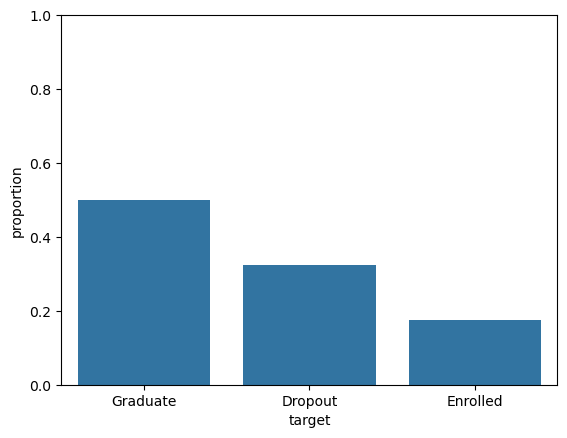

In [18]:
label_distribution = student_data.value_counts(subset=student_data['target'], normalize=True)

fig, ax = plt.subplots()
sns.barplot(data=label_distribution)
ax.set_ylim(0, 1)
plt.show()

### 1.4.2 Continuous Features
<div class="alert alert-block alert-danger">Ich glaube es macht Sinn zuerst die Korrelationen zu überprüfen bevor wir alle Features plotten. Dann können wir nämlich Features mit schwacher Korrelation zum Target raus schmeißen und sparen uns Arbeit beim plotten.</div>

# 2. Correlation Analysis
## 2.1 Features With The Target

## 2.2 Features With Each Other

In [13]:
#
# student_data['target'] = student_data['target'].map(arg={'Dropout':0, 'Enrolled':1, 'Graduate':2})